## **Environment Setup**

In [ ]:
import requests
import json
from pprint import pprint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sqlite3

In [ ]:
# Define the API URL
API_URL = "https://data.iowa.gov/resource/wsde-3id9.json"

# Fetch all data in chunks using pagination
data_list = []
offset = 0
limit = 50000  # Adjust if needed


# While loop to request relevant data, append the data to a list, and then keep looping through available data until no more.

while True:
    response = requests.get(API_URL, params={"$limit": limit, "$offset": offset})
    if response.status_code == 200:
        data_chunk = response.json()
        if not data_chunk:  # Stop when no more data
            break
        data_list.extend(data_chunk)
        offset += limit  # Move to next batch
    else:
        print(f"Error {response.status_code}: Unable to fetch more data")
        break

# Convert to DataFrame
iowa_sales_tax_data = pd.DataFrame(data_list)

In [ ]:
iowa_sales_tax_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126146 entries, 0 to 126145
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   fiscal_year        126146 non-null  object
 1   quarter_ending     126146 non-null  object
 2   county_number      126146 non-null  object
 3   county             126146 non-null  object
 4   business_group     126145 non-null  object
 5   number_of_returns  113672 non-null  object
 6   taxable_sales      113696 non-null  object
 7   computed_tax       113696 non-null  object
 8   percent_of_tax     113697 non-null  object
 9   suppressed         126146 non-null  bool  
dtypes: bool(1), object(9)
memory usage: 8.8+ MB


In [ ]:
iowa_sales_tax_data.sample(10)

,fiscal_year,quarter_ending,county_number,county,business_group,number_of_returns,taxable_sales,computed_tax,percent_of_tax,suppressed
50402,2008,2008-06-01T00:00:00.000,8,Boone,Service,232,5368922,268446,0.0006,False
121806,2022,2022-03-31T00:00:00.000,62,Mahaska,Service,194,7279414,432591,0.0007,False
36579,2006,2005-09-01T00:00:00.000,37,Greene,Eating and Drinking,25,1056159,52808,0.0001,False
5809,2024,2023-09-30T00:00:00.000,45,Howard,Specialty Retail,108,4930893,295854,0.0004,False
19144,2002,2002-03-01T00:00:00.000,81,Sac,Specialty Retail,73,572520,28626,0.0001,False
302,2023,2022-09-30T00:00:00.000,15,Cass,Apparel,18,424085,25445,0.00,False
90082,2016,2015-12-01T00:00:00.000,81,Sac,Apparel,NaN,NaN,NaN,NaN,True
87445,2015,2015-06-01T00:00:00.000,76,Pocahontas,County Totals,253,11086528,663899,0.0011,False
23372,2003,2003-03-01T00:00:00.000,10,Buchanan,Miscellaneous,86,1660547,83027,0.0003,False
30752,2004,2004-06-01T00:00:00.000,84,Sioux,General Merchandise,17,4958029,247901,0.0007,False


## **Using Python Data Cleaning**

Since we **previously accomplished cleaning and analyzing this data in Homework 3**, in summary, here are the steps we want to take to properly clean the data in preparation for more in-depth EDA:

#### Data Outliers Exploration

* We will ensure to set up appropriate safeguards to detect any anomalies among these outlier rows (e.g. cases where only 3/4, 2/4, and 1/4 columns contain S). After our investigation in Homework 3, we discovered that these anomalies have a low amount of observations of **"Number of Returns"** that reflects 'S' values across all 4 columns.


#### Data Type Exploration

* We will identify the distinct data types across all columns within the dataset and respectively sample a value for visual inspection

#### Data Transformation (pending completed Data Type Exploration)

* We will convert the 'S' values to NaN/Null values to clean the data for more rigorous analysis.
* We will convert the **"Taxable Sales" and ""Computed Tax"** columns to numeric values, including removing the '$' and ',' signs.
* We will remove the '%' value from the **"Percent of Tax"** column
* We will transform the values under **"Quarter Ending"** to a 'YYYY/MM/DD' format based on financial quarter end dates


In [ ]:
# Create a copy of the original DataFrame to preserve it
iowa_sales_tax_data_anomalies_review = iowa_sales_tax_data.copy()

columns_to_check = ['number_of_returns', 'taxable_sales', 'computed_tax', 'percent_of_tax']

# Count the number of 'S' values in each row for the specified columns
s_counts = iowa_sales_tax_data_anomalies_review[columns_to_check].isin(['S']).sum(axis=1)

# Identify cases where exactly 3, 2, or 1 columns contain 'S'
cases_3_of_4 = s_counts[s_counts == 3]
cases_2_of_4 = s_counts[s_counts == 2]
cases_1_of_4 = s_counts[s_counts == 1]

# Count the occurrences for each case
count_3_of_4 = len(cases_3_of_4)
count_2_of_4 = len(cases_2_of_4)
count_1_of_4 = len(cases_1_of_4)

# Display the counts
{
    "3/4 Columns Contain 'S'": count_3_of_4,
    "2/4 Columns Contain 'S'": count_2_of_4,
    "1/4 Columns Contain 'S'": count_1_of_4
}


{"3/4 Columns Contain 'S'": 0,
 "2/4 Columns Contain 'S'": 0,
 "1/4 Columns Contain 'S'": 0}

In [ ]:
# Count the number of 'S' values in each row for the specified columns
s_counts = iowa_sales_tax_data_anomalies_review[columns_to_check].isin(['S']).sum(axis=1)

# Identify the indices of rows where exactly 3 or 1 columns contain 'S'
indices_to_remove = s_counts[(s_counts == 3) | (s_counts == 1)].index

# New dataframe excluding rows with partial s values
iowa_sales_tax_data_no_partial_s = iowa_sales_tax_data_anomalies_review.drop(index=indices_to_remove)

# Display the new DataFrame (this will reveal in Jupyter, not print)
iowa_sales_tax_data_no_partial_s


,fiscal_year,quarter_ending,county_number,county,business_group,number_of_returns,taxable_sales,computed_tax,percent_of_tax,suppressed
0,2023,2022-09-30T00:00:00.000,42,Hardin,Apparel,21,357947,21477,0.00,False
1,2023,2022-09-30T00:00:00.000,45,Howard,Service,205,4437987,265848,0.0004,False
2,2023,2022-09-30T00:00:00.000,54,Keokuk,Wholesale,34,1818165,109090,0.0001,False
3,2023,2022-09-30T00:00:00.000,86,Tama,Wholesale,49,4806898,288414,0.0004,False
4,2001,2000-12-01T00:00:00.000,55,Kossuth,Motor Vehicle,31,2821069,141053,0.0004,False
...,...,...,...,...,...,...,...,...,...,...
126141,2024,2024-06-30T00:00:00.000,99,Wright,Specialty Retail,85,1262733,75764,0.0001,False
126142,2024,2024-06-30T00:00:00.000,99,Wright,Utilities and Transportation,87,4837755,290265,0.0004,False
126143,2024,2024-06-30T00:00:00.000,99,Wright,Wholesale,54,2526135,151568,0.0002,False
126144,2024,2024-06-30T00:00:00.000,99,Wright,County Totals,892,28967427,1735254,0.0023,False


In [ ]:
# 1. Convert 'S' values to NaN in the specified columns
iowa_sales_tax_data_no_partial_s[columns_to_check] = iowa_sales_tax_data_no_partial_s[columns_to_check].replace('S', np.nan)

# 2. Clean and convert "Taxable Sales" and "Computed Tax" to numeric

# Define a function to clean monetary columns using raw strings to avoid escape sequence issues
def clean_monetary_column(column):
    return column.replace(r'[$,]', '', regex=True).astype(float)

# Apply the function to "Taxable Sales" and "Computed Tax"
iowa_sales_tax_data_no_partial_s['taxable_sales'] = clean_monetary_column(iowa_sales_tax_data_no_partial_s['taxable_sales'])
iowa_sales_tax_data_no_partial_s['computed_tax'] = clean_monetary_column(iowa_sales_tax_data_no_partial_s['computed_tax'])

# 3. Clean and convert "Percent of Tax" to numeric

# Convert the column to string, replace '%' and 'nan', then convert to float
iowa_sales_tax_data_no_partial_s['percent_of_tax'] = (
    iowa_sales_tax_data_no_partial_s['percent_of_tax']
    .astype(str)                     # Ensure all entries are strings
    .str.replace('%', '', regex=False)  # Remove the '%' symbol
    .replace('nan', np.nan)         # Convert 'nan' strings back to NaN
    .astype(float)                   # Convert the column to float
)

# 4. Handle "Number of Returns" column

# Assuming "Number of Returns" should be numeric, remove commas and convert to float
iowa_sales_tax_data_no_partial_s['number_of_returns'] = (
    iowa_sales_tax_data_no_partial_s['number_of_returns']
    .str.replace(',', '', regex=False)
    .astype(float)
)

# 5. Handle "Quarter Ending" column

# Define a function to parse "Quarter Ending" strings to datetime
def parse_quarter_ending(quarter_str):
    try:
        return pd.to_datetime(quarter_str)
    except:
        return pd.NaT

# Apply the function to "Quarter Ending"
iowa_sales_tax_data_no_partial_s['quarter_ending'] = iowa_sales_tax_data_no_partial_s['quarter_ending'].apply(parse_quarter_ending)


In [ ]:
iowa_sales_tax_data_no_partial_s.sample(15)

,fiscal_year,quarter_ending,county_number,county,business_group,number_of_returns,taxable_sales,computed_tax,percent_of_tax,suppressed
55477,2009,2009-06-01,3,Allamakee,Miscellaneous,69.0,1267949.0,76077.0,0.0002,False
4072,2023,2023-06-30,10,Buchanan,County Totals,1250.0,53539350.0,3207882.0,0.0041,False
76152,2013,2013-06-01,4,Appanoose,Utilities and Transportation,20.0,2906765.0,174406.0,0.0003,False
82809,2015,2014-09-01,16,Cedar,Home Furnishings,6.0,365966.0,21958.0,0.0000,False
73551,2013,2012-12-01,3,Allamakee,Food Dealers,12.0,1457633.0,87458.0,0.0002,False
23748,2003,2003-03-01,39,Guthrie,Home Furnishings,7.0,180363.0,9018.0,0.0000,False
49379,2008,2008-03-01,29,Des Moines,Building Materials,18.0,13125919.0,656296.0,0.0018,False
97524,2017,2017-06-01,68,Monroe,Wholesale,11.0,1151269.0,69076.0,0.0001,False
16518,2002,2001-09-01,78,Pottawattamie,Apparel,38.0,6097625.0,304881.0,0.0008,False
116160,2021,2021-03-01,23,Clinton,Service,451.0,12505075.0,733705.0,0.0013,False


In [ ]:
iowa_sales_tax_data_no_partial_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126146 entries, 0 to 126145
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   fiscal_year        126146 non-null  object        
 1   quarter_ending     126146 non-null  datetime64[ns]
 2   county_number      126146 non-null  object        
 3   county             126146 non-null  object        
 4   business_group     126145 non-null  object        
 5   number_of_returns  113672 non-null  float64       
 6   taxable_sales      113696 non-null  float64       
 7   computed_tax       113696 non-null  float64       
 8   percent_of_tax     113697 non-null  float64       
 9   suppressed         126146 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(4), object(4)
memory usage: 8.8+ MB


In [ ]:
iowa_sales_tax_data_no_partial_s.describe()

,quarter_ending,number_of_returns,taxable_sales,computed_tax,percent_of_tax
count,126146,113672.000000,1.136960e+05,1.136960e+05,113697.000000
mean,2012-04-21 04:14:33.045518592,183.589415,1.741004e+07,9.970179e+05,0.001889
min,2000-03-01 00:00:00,5.000000,7.010000e+02,4.200000e+01,0.000000
25%,2006-03-01 00:00:00,16.000000,1.190512e+06,6.643475e+04,0.000100
50%,2012-06-01 00:00:00,37.000000,2.781698e+06,1.561110e+05,0.000300
75%,2018-06-01 00:00:00,114.000000,8.125197e+06,4.591312e+05,0.000900
max,2024-06-30 00:00:00,202324.000000,1.318421e+10,7.889983e+08,1.000000
std,NaN,1822.856375,1.691492e+08,1.004641e+07,0.015533


## **Review of Data Type and Data Transformation**

Analysis:

* 202324.000000 as a max for "Number of Returns" is an exceptionally high value. Same goes 1.318421e+10 in "Taxable Sales" and 7.889983e+08 in "Computed Tax". These outliers likely will significantly skew our analysis, evidenced by our standard deviations.
* Now that we have datetime and we know that the Quarter Ending operates based on fiscal year, it's time to update the quarter ending dates to the actual dates - we discover in the cell above that between the years 2000 and 2024, there is a pattern in fiscal quarter ending months which follows the quarterly basis of the typical fiscal year (Gregorian calendar). In this case, the fiscal quarters end on 03-31, 06-30, 09-40, and 12-31, which is consistent with the months listed in the dataframe. We can safely update these dates with the correct datetimes for proper analysis going forward.

Next Steps:

* Drop NaN rows - this amounts to about 12,477 entries being dropped out of 126146 rows or ~9.8%.
* Update Quarter Endings dates to: 03-31, 06-30, 09-30, and 12-31 but maintain the years



In [ ]:
# Define the columns to check for NaN
columns_to_dropna = ['number_of_returns', 'taxable_sales', 	'computed_tax',	'percent_of_tax']

# 1. Drop rows with NaN in specified columns
iowa_cleaned_sales_tax_data = iowa_sales_tax_data_no_partial_s.dropna(subset=columns_to_dropna).copy()

# Verify the number of rows dropped
initial_count = len(iowa_sales_tax_data_no_partial_s)
final_count = len(iowa_cleaned_sales_tax_data)
rows_dropped = initial_count - final_count
print(f"Rows dropped due to NaN values: {rows_dropped}")


Rows dropped due to NaN values: 12483


In [ ]:
# Function to update 'Quarter Ending' to the last day of the quarter
def update_quarter_end_date(date):
    if pd.isna(date):
        return pd.NaT
    month = date.month
    year = date.year
    if month == 3:
        return pd.Timestamp(year=year, month=3, day=31)
    elif month == 6:
        return pd.Timestamp(year=year, month=6, day=30)
    elif month == 9:
        return pd.Timestamp(year=year, month=9, day=30)
    elif month == 12:
        return pd.Timestamp(year=year, month=12, day=31)
    else:
        # Handle unexpected months if any
        print(f"Unexpected month in Quarter Ending: {month}")
        return date  # Or choose to set as NaT or another appropriate value

# Apply the function to 'Quarter Ending' column
iowa_cleaned_sales_tax_data['quarter_ending'] = iowa_cleaned_sales_tax_data['quarter_ending'].apply(update_quarter_end_date)

# Verify the changes
iowa_cleaned_sales_tax_data[['quarter_ending']].head()


,quarter_ending
0,2022-09-30
1,2022-09-30
2,2022-09-30
3,2022-09-30
4,2000-12-31


In [ ]:
# Function to identify all distinct data types within each column
def get_distinct_data_types(df):
    column_data_types = {}
    for col in df.columns:
        # Apply a set comprehension to capture the type of each value in the column
        distinct_types = {type(value) for value in df[col].dropna()}  # Exclude NaN values
        column_data_types[col] = distinct_types
    return column_data_types

# Get all distinct data types for each column
distinct_data_types = get_distinct_data_types(iowa_cleaned_sales_tax_data)

# Create a DataFrame summarizing distinct data types for each column
data_type_summary = pd.DataFrame({
    'Column Name': distinct_data_types.keys(),
    'Distinct Data Types': distinct_data_types.values()
})

# Display the summary DataFrame
data_type_summary


,Column Name,Distinct Data Types
0,fiscal_year,{<class 'str'>}
1,quarter_ending,{<class 'pandas._libs.tslibs.timestamps.Timest...
2,county_number,{<class 'str'>}
3,county,{<class 'str'>}
4,business_group,{<class 'str'>}
5,number_of_returns,{<class 'float'>}
6,taxable_sales,{<class 'float'>}
7,computed_tax,{<class 'float'>}
8,percent_of_tax,{<class 'float'>}
9,suppressed,{<class 'bool'>}


# **Joining the data on Sales Tax and Property Assessment Levy Rates in Iowa**

We will start off with using the memory function [Documentation on In-Memory Databases](https://www.sqlite.org/inmemorydb.html) to store the dataframe we've created into a SQL table within our temporary database.

In [ ]:
iowa_levy_rates_clean = pd.read_csv("/content/drive/MyDrive/BUS32120_Final_Data/iowa_levy_rates_clean.csv")
iowa_levy_rates_clean.head()

,Unnamed: 0,unique_line_id,fiscal_year,type,levy_authority_1,levy_authority_2,county_fip,county_name,urban_rate,rural_rate,debt_rate,tif_rate_urban,tif_rate_rural,city_fips,city_name,co_subdivision_fip,rate_ratio
0,0,2002_AG EXTENSIONS_01C001,2002,AG EXTENSIONS,01C001,ADAIR COUNTY AG EXTENSION,19001,ADAIR,0.24828,0.24828,0.24828,0.24828,0.24828,NaN,NaN,NaN,1.0
1,1,2002_AG EXTENSIONS_02C001,2002,AG EXTENSIONS,02C001,ADAMS COUNTY AG EXTENSION,19003,ADAMS,0.30000,0.30000,0.30000,0.30000,0.30000,NaN,NaN,NaN,1.0
2,2,2002_AG EXTENSIONS_03C001,2002,AG EXTENSIONS,03C001,ALLAMAKEE COUNTY AG EXTENSION,19005,ALLAMAKEE,0.16203,0.16203,0.16203,0.16203,0.16203,NaN,NaN,NaN,1.0
3,3,2002_AG EXTENSIONS_04C001,2002,AG EXTENSIONS,04C001,APPANOOSE COUNTY AG EXTENSION,19007,APPANOOSE,0.27025,0.27025,0.27025,0.27025,0.27025,NaN,NaN,NaN,1.0
4,4,2002_AG EXTENSIONS_05C001,2002,AG EXTENSIONS,05C001,AUDUBON COUNTY AG EXTENSION,19009,AUDUBON,0.26861,0.26861,0.26861,0.26861,0.26861,NaN,NaN,NaN,1.0


In [ ]:
# Create an in-memory SQLite database - memory
conn = sqlite3.connect(':memory:')

# Write the DataFrame to a SQL table named "sales_tax_data_clean"
iowa_cleaned_sales_tax_data.to_sql("iowa_sales_tax_data_clean", conn, if_exists="replace", index=False)
iowa_levy_rates_clean.to_sql("iowa_levy_rates_clean", conn, if_exists="replace", index=False)


print("DataFrame has been written to the 'iowa_sales_tax_data_clean' table in memory.")
print("DataFrame has been written to the 'iowa_levy_rates_clean' table in memory.")


DataFrame has been written to the 'iowa_sales_tax_data_clean' table in memory.
DataFrame has been written to the 'iowa_levy_rates_clean' table in memory.


In [ ]:
c = conn.cursor()

# List all tables
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = c.fetchall()
print("Tables in the database:")
for table in tables:
    print(table)

# Inspect the creation SQL for your table
c.execute("SELECT sql FROM sqlite_master WHERE tbl_name = 'iowa_sales_tax_data_clean' AND type='table';")
table_sql = c.fetchall()
print("\nTable creation statement for 'iowa_sales_tax_data_clean':")
for row in table_sql:
    print(row[0])

# Inspect the creation SQL for your table
c.execute("SELECT sql FROM sqlite_master WHERE tbl_name = 'iowa_levy_rates_clean' AND type='table';")
table_sql = c.fetchall()
print("\nTable creation statement for 'iowa_levy_rates_clean':")
for row in table_sql:
    print(row[0])


Tables in the database:
('iowa_sales_tax_data_clean',)
('iowa_levy_rates_clean',)

Table creation statement for 'iowa_sales_tax_data_clean':
CREATE TABLE "iowa_sales_tax_data_clean" (
"fiscal_year" TEXT,
  "quarter_ending" TIMESTAMP,
  "county_number" TEXT,
  "county" TEXT,
  "business_group" TEXT,
  "number_of_returns" REAL,
  "taxable_sales" REAL,
  "computed_tax" REAL,
  "percent_of_tax" REAL,
  "suppressed" INTEGER
)

Table creation statement for 'iowa_levy_rates_clean':
CREATE TABLE "iowa_levy_rates_clean" (
"Unnamed: 0" INTEGER,
  "unique_line_id" TEXT,
  "fiscal_year" INTEGER,
  "type" TEXT,
  "levy_authority_1" TEXT,
  "levy_authority_2" TEXT,
  "county_fip" INTEGER,
  "county_name" TEXT,
  "urban_rate" REAL,
  "rural_rate" REAL,
  "debt_rate" REAL,
  "tif_rate_urban" REAL,
  "tif_rate_rural" REAL,
  "city_fips" REAL,
  "city_name" TEXT,
  "co_subdivision_fip" REAL,
  "rate_ratio" REAL
)


In [ ]:
# Selecting first three rows of data from the iowa_sales_tax_data table
query = """SELECT * FROM iowa_sales_tax_data_clean LIMIT 3; """

c.execute(query)

for _ in c.fetchall():
    print(_, "\n")

('2023', '2022-09-30 00:00:00', '42', 'Hardin', 'Apparel', 21.0, 357947.0, 21477.0, 0.0, 0) 

('2023', '2022-09-30 00:00:00', '45', 'Howard', 'Service', 205.0, 4437987.0, 265848.0, 0.0004, 0) 

('2023', '2022-09-30 00:00:00', '54', 'Keokuk', 'Wholesale', 34.0, 1818165.0, 109090.0, 0.0001, 0) 



In [ ]:
# Selecting first three rows of data from the iowa_levy_rates_clean table


query = """SELECT * FROM iowa_levy_rates_clean LIMIT 3; """

c.execute(query)

for _ in c.fetchall():
    print(_, "\n")

(0, '2002_AG EXTENSIONS_01C001', 2002, 'AG EXTENSIONS', '01C001', 'ADAIR COUNTY AG EXTENSION', 19001, 'ADAIR', 0.24828, 0.24828, 0.24828, 0.24828, 0.24828, None, None, None, 1.0) 

(1, '2002_AG EXTENSIONS_02C001', 2002, 'AG EXTENSIONS', '02C001', 'ADAMS COUNTY AG EXTENSION', 19003, 'ADAMS', 0.3, 0.3, 0.3, 0.3, 0.3, None, None, None, 1.0) 

(2, '2002_AG EXTENSIONS_03C001', 2002, 'AG EXTENSIONS', '03C001', 'ALLAMAKEE COUNTY AG EXTENSION', 19005, 'ALLAMAKEE', 0.16203, 0.16203, 0.16203, 0.16203, 0.16203, None, None, None, 1.0) 



In [ ]:
# Testing a join between the two datasets using the county name as the foreign key

query = """SELECT * FROM iowa_levy_rates_clean
            JOIN iowa_sales_tax_data_clean
            ON iowa_levy_rates_clean.county_name=iowa_sales_tax_data_clean.county
            LIMIT 3; """

c.execute(query)

for _ in c.fetchall():
    print(_, "\n")



(0, '2002_AG EXTENSIONS_01C001', 2002, 'AG EXTENSIONS', '01C001', 'ADAIR COUNTY AG EXTENSION', 19001, 'ADAIR', 0.24828, 0.24828, 0.24828, 0.24828, 0.24828, None, None, None, 1.0, 2000, '2000-03-31 00:00:00', '1', 'ADAIR', 'Building Materials', 12.0, 822793.0, 41140.0, 0.0001) 

(0, '2002_AG EXTENSIONS_01C001', 2002, 'AG EXTENSIONS', '01C001', 'ADAIR COUNTY AG EXTENSION', 19001, 'ADAIR', 0.24828, 0.24828, 0.24828, 0.24828, 0.24828, None, None, None, 1.0, 2000, '2000-03-31 00:00:00', '1', 'ADAIR', 'County Totals', 331.0, 11349440.0, 567472.0, 0.0018) 

(0, '2002_AG EXTENSIONS_01C001', 2002, 'AG EXTENSIONS', '01C001', 'ADAIR COUNTY AG EXTENSION', 19001, 'ADAIR', 0.24828, 0.24828, 0.24828, 0.24828, 0.24828, None, None, None, 1.0, 2000, '2000-03-31 00:00:00', '1', 'ADAIR', 'Eating and Drinking', 25.0, 1400611.0, 70031.0, 0.0002) 



## **Observations**

Discrepancies between datasets:

* Our unique, matching identification across the two sets of data are the county names--however, we can observe that in the levy rates data, the county names are completely capitalized while in the sales tax data, they follow proper name conventions.

To address the issue of normalization between the two datasets, we will:

* Perform an UPPER case update to the sales tax data.
* Ensure that datatypes are properly assigned to respective columns (e.g. fiscal_year is INT)

In [ ]:
# Update the 'county' column in iowa_sales_tax_data_clean to uppercase
query = """
UPDATE iowa_sales_tax_data_clean
SET county = UPPER(county);
"""
c.execute(query)

# Verify the update
query = """SELECT county FROM iowa_sales_tax_data_clean LIMIT 5;"""
c.execute(query)
print("Updated county values:")
for row in c.fetchall():
    print(row[0])

# Testing the join key again
query = """SELECT * FROM iowa_levy_rates_clean
            JOIN iowa_sales_tax_data_clean
            ON iowa_levy_rates_clean.county_name=iowa_sales_tax_data_clean.county
            LIMIT 3; """

c.execute(query)
print("\nJoin query results after update:")
for row in c.fetchall():
    print(row, "\n")


Updated county values:
HARDIN
HOWARD
KEOKUK
TAMA
KOSSUTH

Join query results after update:
(0, '2002_AG EXTENSIONS_01C001', 2002, 'AG EXTENSIONS', '01C001', 'ADAIR COUNTY AG EXTENSION', 19001, 'ADAIR', 0.24828, 0.24828, 0.24828, 0.24828, 0.24828, None, None, None, 1.0, '2000', '2000-03-31 00:00:00', '1', 'ADAIR', 'Building Materials', 12.0, 822793.0, 41140.0, 0.0001, 0) 

(0, '2002_AG EXTENSIONS_01C001', 2002, 'AG EXTENSIONS', '01C001', 'ADAIR COUNTY AG EXTENSION', 19001, 'ADAIR', 0.24828, 0.24828, 0.24828, 0.24828, 0.24828, None, None, None, 1.0, '2000', '2000-03-31 00:00:00', '1', 'ADAIR', 'County Totals', 331.0, 11349440.0, 567472.0, 0.0018, 0) 

(0, '2002_AG EXTENSIONS_01C001', 2002, 'AG EXTENSIONS', '01C001', 'ADAIR COUNTY AG EXTENSION', 19001, 'ADAIR', 0.24828, 0.24828, 0.24828, 0.24828, 0.24828, None, None, None, 1.0, '2000', '2000-03-31 00:00:00', '1', 'ADAIR', 'Eating and Drinking', 25.0, 1400611.0, 70031.0, 0.0002, 0) 



In [ ]:
# Step 1: Create a new table with the correct data types
create_table_query = """
CREATE TABLE iowa_sales_tax_data_clean_new (
    fiscal_year INTEGER,
    quarter_ending TIMESTAMP,
    county_number TEXT,
    county TEXT,
    business_group TEXT,
    number_of_returns REAL,
    taxable_sales REAL,
    computed_tax REAL,
    percent_of_tax REAL
);
"""

c.execute(create_table_query)

# Step 2: Copy data from the old table while converting fiscal_year to INTEGER
insert_data_query = """
INSERT INTO iowa_sales_tax_data_clean_new
SELECT CAST(fiscal_year AS INTEGER), quarter_ending, county_number, county,
       business_group, number_of_returns, taxable_sales, computed_tax, percent_of_tax
FROM iowa_sales_tax_data_clean;
"""
c.execute(insert_data_query)

# Step 3: Drop the old table
c.execute("DROP TABLE iowa_sales_tax_data_clean;")

# Step 4: Rename the new table to match the original table name
c.execute("ALTER TABLE iowa_sales_tax_data_clean_new RENAME TO iowa_sales_tax_data_clean;")

# Commit changes
conn.commit()

# Verify that the schema now has fiscal_year as INTEGER
c.execute("SELECT sql FROM sqlite_master WHERE tbl_name = 'iowa_sales_tax_data_clean' AND type='table';")
table_sql = c.fetchall()
print("\nTable creation statement for 'iowa_sales_tax_data_clean':")
for row in table_sql:
    print(row[0])


# Compare with iowa_lev_rates_clean data as well!
c.execute("SELECT sql FROM sqlite_master WHERE tbl_name = 'iowa_levy_rates_clean' AND type='table';")
table_sql = c.fetchall()
print("\nTable creation statement for 'iowa_levy_rates_clean':")
for row in table_sql:
    print(row[0])



Table creation statement for 'iowa_sales_tax_data_clean':
CREATE TABLE "iowa_sales_tax_data_clean" (
    fiscal_year INTEGER,
    quarter_ending TIMESTAMP,
    county_number TEXT,
    county TEXT,
    business_group TEXT,
    number_of_returns REAL,
    taxable_sales REAL,
    computed_tax REAL,
    percent_of_tax REAL
)

Table creation statement for 'iowa_levy_rates_clean':
CREATE TABLE "iowa_levy_rates_clean" (
"Unnamed: 0" INTEGER,
  "unique_line_id" TEXT,
  "fiscal_year" INTEGER,
  "type" TEXT,
  "levy_authority_1" TEXT,
  "levy_authority_2" TEXT,
  "county_fip" INTEGER,
  "county_name" TEXT,
  "urban_rate" REAL,
  "rural_rate" REAL,
  "debt_rate" REAL,
  "tif_rate_urban" REAL,
  "tif_rate_rural" REAL,
  "city_fips" REAL,
  "city_name" TEXT,
  "co_subdivision_fip" REAL,
  "rate_ratio" REAL
)


# **Reviewing the Updated Datasets**

In [ ]:
# Joining the data again using both county name and the fiscal year to uniquely tie data from across both datasets

query = """SELECT * FROM iowa_levy_rates_clean
            JOIN iowa_sales_tax_data_clean
            ON iowa_levy_rates_clean.county_name=iowa_sales_tax_data_clean.county
            AND iowa_levy_rates_clean.fiscal_year=iowa_sales_tax_data_clean.fiscal_year
            LIMIT 10; """

c.execute(query)

for _ in c.fetchall():
    print(_, "\n")



(0, '2002_AG EXTENSIONS_01C001', 2002, 'AG EXTENSIONS', '01C001', 'ADAIR COUNTY AG EXTENSION', 19001, 'ADAIR', 0.24828, 0.24828, 0.24828, 0.24828, 0.24828, None, None, None, 1.0, 2002, '2001-09-30 00:00:00', '1', 'ADAIR', 'Building Materials', 11.0, 1036483.0, 51824.0, 0.0001) 

(0, '2002_AG EXTENSIONS_01C001', 2002, 'AG EXTENSIONS', '01C001', 'ADAIR COUNTY AG EXTENSION', 19001, 'ADAIR', 0.24828, 0.24828, 0.24828, 0.24828, 0.24828, None, None, None, 1.0, 2002, '2001-09-30 00:00:00', '1', 'ADAIR', 'County Totals', 331.0, 13360453.0, 668023.0, 0.0018) 

(0, '2002_AG EXTENSIONS_01C001', 2002, 'AG EXTENSIONS', '01C001', 'ADAIR COUNTY AG EXTENSION', 19001, 'ADAIR', 0.24828, 0.24828, 0.24828, 0.24828, 0.24828, None, None, None, 1.0, 2002, '2001-09-30 00:00:00', '1', 'ADAIR', 'Eating and Drinking', 22.0, 1842151.0, 92108.0, 0.0002) 

(0, '2002_AG EXTENSIONS_01C001', 2002, 'AG EXTENSIONS', '01C001', 'ADAIR COUNTY AG EXTENSION', 19001, 'ADAIR', 0.24828, 0.24828, 0.24828, 0.24828, 0.24828, None,

In [ ]:
# Joining the data again using both county name=Polk and the fiscal year to uniquely tie data from across both datasets


query = """SELECT * FROM iowa_levy_rates_clean
            JOIN iowa_sales_tax_data_clean
            ON iowa_levy_rates_clean.county_name=iowa_sales_tax_data_clean.county
            AND iowa_levy_rates_clean.fiscal_year=iowa_sales_tax_data_clean.fiscal_year
            WHERE iowa_levy_rates_clean.county_name='POLK'
            LIMIT 10; """

c.execute(query)

for _ in c.fetchall():
    print(_, "\n")



(77, '2002_AG EXTENSIONS_77C001', 2002, 'AG EXTENSIONS', '77C001', 'POLK COUNTY AG EXTENSION', 19153, 'POLK', 0.03572, 0.03572, 0.03572, 0.03572, 0.03572, None, None, None, 1.0, 2002, '2001-09-30 00:00:00', '77', 'POLK', 'Apparel', 228.0, 44883242.0, 2244162.0, 0.006) 

(77, '2002_AG EXTENSIONS_77C001', 2002, 'AG EXTENSIONS', '77C001', 'POLK COUNTY AG EXTENSION', 19153, 'POLK', 0.03572, 0.03572, 0.03572, 0.03572, 0.03572, None, None, None, 1.0, 2002, '2001-09-30 00:00:00', '77', 'POLK', 'Building Materials', 166.0, 106227870.0, 5311394.0, 0.0143) 

(77, '2002_AG EXTENSIONS_77C001', 2002, 'AG EXTENSIONS', '77C001', 'POLK COUNTY AG EXTENSION', 19153, 'POLK', 0.03572, 0.03572, 0.03572, 0.03572, 0.03572, None, None, None, 1.0, 2002, '2001-09-30 00:00:00', '77', 'POLK', 'County Totals', 9843.0, 1613435264.0, 80671763.0, 0.2174) 

(77, '2002_AG EXTENSIONS_77C001', 2002, 'AG EXTENSIONS', '77C001', 'POLK COUNTY AG EXTENSION', 19153, 'POLK', 0.03572, 0.03572, 0.03572, 0.03572, 0.03572, None, No

In [ ]:

# This query aggregates key metrics by business group for POLK county.
# We are using st as an ALIAS for iowa_sales_tax_data_clean and lr for the other table
# We are selecting the total taxable sales and computed tax by each business group across all years
# We are also joining the average urban rate across all years


query = """
SELECT st.business_group,
       COUNT(*) AS num_records,
       SUM(st.taxable_sales) AS total_taxable_sales,
       SUM(st.computed_tax) AS total_computed_tax,
       AVG(lr.urban_rate) AS avg_urban_rate
FROM iowa_levy_rates_clean AS lr
JOIN iowa_sales_tax_data_clean AS st
  ON lr.county_name = st.county
  AND lr.fiscal_year = st.fiscal_year
WHERE lr.county_name = 'POLK'
GROUP BY st.business_group
;
"""

c.execute(query)
for row in c.fetchall():
    print(row, "\n")


('Apparel', 6368, 335646886972.0, 19472972408.0, 3.4625085741205517) 

('Building Materials', 6368, 943977952365.0, 54989020944.0, 3.4625085741205517) 

('County Totals', 6368, 12732716573467.0, 738307643838.0, 3.4625085741205517) 

('Eating and Drinking', 6368, 1372483299002.0, 80268955829.0, 3.4625085741205517) 

('Food Dealers', 6368, 830991212820.0, 48527099572.0, 3.4625085741205517) 

('General Merchandise', 6368, 1230046211951.0, 71032799599.0, 3.4625085741205517) 

('Home Furnishings', 6368, 573841123940.0, 33290309989.0, 3.4625085741205517) 

('Miscellaneous', 6368, 1049325041493.0, 61358771238.0, 3.4625085741205517) 

('Motor Vehicle', 6368, 573605664197.0, 33562884183.0, 3.4625085741205517) 

('Service', 6368, 2103462927418.0, 120068327172.0, 3.4625085741205517) 

('Specialty Retail', 6368, 1149430207778.0, 67159598670.0, 3.4625085741205517) 

('Utilities and Transportation', 6368, 996203704863.0, 57439262884.0, 3.4625085741205517) 

('Wholesale', 6368, 1573702340767.0, 91137


# **Refresher on the Iowa Levy Rate Data**

Beginning: 2001-07
Last Updated: 2024-07-17

#### Overview of Columns (15)

| Column Name          | Description                                                                 | Data Type |
|----------------------|---------------------------------------------------------------------------|-----------|
| `unique_line_id`     | An identifier to denote unique lines of data.                            | Text      |
| `co_subdivision_fip` | A ten-digit Federal Information Processing Series code for county subdivisions. | Text      |
| `urban_rate`        | Rate applied to property considered urban.                                | Number    |
| `rural_rate`        | Rate applied to property considered rural.                                | Number    |
| `debt_rate`         | Rate applied to the levy authority's debt.                               | Number    |
| `tif_rate_urban`    | TIF Rate applied to urban properties.                                    | Number    |
| `tif_rate_rural`    | TIF Rate applied to rural properties.                                    | Number    |
| `fiscal_year`       | The state fiscal year (July 1 to June 30, named after ending year).     | Number    |
| `type`             | Category of levy authorities.                                           | Text      |
| `levy_authority_1`  | Unique ID for the levy authority.                                      | Text      |
| `levy_authority_2`  | Name of the levy authority.                                           | Text      |
| `county_fip`        | A five-digit Federal Information Processing Series code for counties.  | Text      |
| `county_name`       | Name of the county the levy authority is located in.                   | Text      |
| `city_fips`        | A seven-digit Federal Information Processing Series code for cities.   | Text      |
| `city_name`        | Name of the city where the levy authority is located (if applicable). | Text      |




*How many counties are there in Iowa?*

There are **99** counties in Iowa according to https://www.census.gov/geographies/reference-files/2010/geo/state-local-geo-guides-2010/iowa.html

*What is a levy rate?*

There are a number of different taxing districts in a jurisdiction, each with a different levy rate. Each year the county auditor determines for that district a levy rate that will yield enough money to fund the different entities in that district. The entities include local schools, counties, cities, townships, community colleges, local assessors, and others. Since more than one taxing authority is calculating a tax rate for the property, all the rates are added together, resulting in a single tax levy called a consolidated levy. This consolidated levy is always the result of two or more tax rates established by different government entities. - https://storycountyiowa.gov/FAQ.aspx?QID=267

*What is a levy authority?*

"A Levy Authority is a governmental entity with statutory authority to levy property taxes. These entities include counties, cities, school districts, townships, community colleges, local assessors, and others." - https://claycounty.iowa.gov/faqs/


*What are the different levy authorities in Iowa?*


- **K-12 Schools** – Public school districts levying taxes for education.
- **Counties** – County governments funding local services.
- **Cities** – Municipal governments levying taxes for city infrastructure and services.
- **Community Colleges** – Area community colleges levying taxes for post-secondary education.
- **County Hospitals** – Public hospitals with taxing authority for healthcare services.
- **Assessors** – Offices responsible for property valuation.
- **Townships** – Local township governments providing rural services.
- **Agricultural Extension (Ag Extension)** – Entities funding agricultural and community education.
- **Sanitary Sewer** – Districts levying taxes for water treatment and waste management.
- **Miscellaneous** – Other special-purpose entities with taxing authority.
- **State** – The state government’s role in property tax allocation.

[Property Taxes by Type of Taxing Authority](https://drive.google.com/uc?export=download&id=1890bRVFWS22E4kSPdw2xbUkfQ0_qBzpb)


# **Reviewing the growth of taxable sales in the Home Furnishings business group YoY**


In [ ]:
# This query retrieves quarterly taxable sales for Home Furnishings in POLK county and
# calculates the total taxable sales for each fiscal year using a window function.
# The results are then ordered by fiscal year.

query = """
SELECT
    fiscal_year,
    business_group,
    taxable_sales,
    SUM(taxable_sales) OVER (PARTITION BY fiscal_year) AS total_taxable_sales_by_fy
FROM iowa_sales_tax_data_clean
WHERE county = 'POLK'
AND business_group = 'Home Furnishings'
ORDER BY fiscal_year;
"""
# Retrieve the column names from the cursor description
headers = [desc[0] for desc in c.description]
print(headers)

c.execute(query)
for row in c.fetchall():
    print(row)


['Unnamed: 0', 'unique_line_id', 'fiscal_year', 'type', 'levy_authority_1', 'levy_authority_2', 'county_fip', 'county_name', 'urban_rate', 'rural_rate', 'debt_rate', 'tif_rate_urban', 'tif_rate_rural', 'city_fips', 'city_name', 'co_subdivision_fip', 'rate_ratio', 'fiscal_year', 'quarter_ending', 'county_number', 'county', 'business_group', 'number_of_returns', 'taxable_sales', 'computed_tax', 'percent_of_tax']
(2000, 'Home Furnishings', 75731999.0, 150017758.0)
(2000, 'Home Furnishings', 74285759.0, 150017758.0)
(2001, 'Home Furnishings', 75156239.0, 300460900.0)
(2001, 'Home Furnishings', 85240030.0, 300460900.0)
(2001, 'Home Furnishings', 70630120.0, 300460900.0)
(2001, 'Home Furnishings', 69434511.0, 300460900.0)
(2002, 'Home Furnishings', 68149799.0, 310579333.0)
(2002, 'Home Furnishings', 96140662.0, 310579333.0)
(2002, 'Home Furnishings', 72275993.0, 310579333.0)
(2002, 'Home Furnishings', 74012879.0, 310579333.0)
(2003, 'Home Furnishings', 70239397.0, 305158810.0)
(2003, 'Home F

In [ ]:
# This query calculates the quarter-over-quarter change in computed_tax for Home Furnishings in POLK county.
# It uses a subquery with the LAG window function
# We are comparing each computed_tax to the previous fiscal year's value, then filtering out rows where the change is zero.
# We are ordering by the fiscal year
# We are also filtering for only when changes occur


query = """
SELECT *
FROM (
    SELECT
        st.fiscal_year,
        st.business_group,
        st.county,
        st.computed_tax,
        LAG(st.computed_tax) OVER (PARTITION BY st.business_group ORDER BY st.fiscal_year) AS prev_computed_tax,
        st.computed_tax - LAG(st.computed_tax) OVER (PARTITION BY st.business_group ORDER BY st.fiscal_year) AS change_in_computed_tax
    FROM iowa_sales_tax_data_clean AS st
    WHERE st.county = 'POLK'
      AND st.business_group = 'Home Furnishings'
) AS sub
WHERE change_in_computed_tax IS NULL OR change_in_computed_tax <> 0.0
ORDER BY fiscal_year;
"""

c.execute(query)
# Retrieve headers from the cursor description
headers = [desc[0] for desc in c.description]
print(headers)
for row in c.fetchall():
    print(row)


['fiscal_year', 'business_group', 'county', 'computed_tax', 'prev_computed_tax', 'change_in_computed_tax']
(2000, 'Home Furnishings', 'POLK', 3786600.0, None, None)
(2000, 'Home Furnishings', 'POLK', 3714288.0, 3786600.0, -72312.0)
(2001, 'Home Furnishings', 'POLK', 3757812.0, 3714288.0, 43524.0)
(2001, 'Home Furnishings', 'POLK', 4262002.0, 3757812.0, 504190.0)
(2001, 'Home Furnishings', 'POLK', 3531506.0, 4262002.0, -730496.0)
(2001, 'Home Furnishings', 'POLK', 3471726.0, 3531506.0, -59780.0)
(2002, 'Home Furnishings', 'POLK', 3407490.0, 3471726.0, -64236.0)
(2002, 'Home Furnishings', 'POLK', 4807033.0, 3407490.0, 1399543.0)
(2002, 'Home Furnishings', 'POLK', 3613800.0, 4807033.0, -1193233.0)
(2002, 'Home Furnishings', 'POLK', 3700644.0, 3613800.0, 86844.0)
(2003, 'Home Furnishings', 'POLK', 3511970.0, 3700644.0, -188674.0)
(2003, 'Home Furnishings', 'POLK', 4503959.0, 3511970.0, 991989.0)
(2003, 'Home Furnishings', 'POLK', 3541367.0, 4503959.0, -962592.0)
(2003, 'Home Furnishings', 

## Analysis of Growth of Taxable Sales in Home Furnishings

This analysis examines the quarterly changes in **computed_tax** for the Home Furnishings business group in POLK county. Note that **computed_tax** represents the computed retail sales tax filed in the quarter by businesses in the group, with values suppressed (set to NULL) when fewer than five returns are filed. County totals, however, include these suppressed values.

---

Similar to Jasper County, from 2000 to 2006 in Polk County, taxable sales exhibited remarkable consistency, indicating a stable market environment. As anticipated, a significant dip in taxable sales emerged starting in 2007, aligning with the onset of the housing crisis in America. This decline was particularly pronounced between 2005 and 2006, where the median taxable sales dropped sharply. While this downturn doesn't directly signify a housing bubble, it does suggest potential correlations between home furnishing sales and broader economic factors, such as the fluctuations in mortgage-backed securities during that period.

The year 2020 presented a stark contrast, marked by an incredible spike in taxable sales. This surge coincided with historically low mortgage rates—around 3% or less—and the onset of the COVID-19 pandemic. These compounding factors likely drove individuals to purchase homes and invest more in home furnishings as they adapted to lockdowns and remote living conditions

# **Reviewing Relationships between Tax Data and Levy Rate Data**

In [ ]:
# This query aggregates computed tax and urban rate by fiscal year for POLK county by joining the sales tax data (st) with the levy rates data (lr).
# The subquery groups data by fiscal_year to compute total computed tax and average urban rate
# The outer query selects these values and orders them by fiscal year.

query = """
SELECT
    sub.fiscal_year,
    sub.total_computed_tax,
    sub.avg_urban_rate
FROM (
    SELECT
        st.fiscal_year,
        SUM(st.computed_tax) AS total_computed_tax,
        AVG(lr.urban_rate) AS avg_urban_rate
    FROM iowa_sales_tax_data_clean AS st
    JOIN iowa_levy_rates_clean AS lr
      ON st.county = lr.county_name
      AND st.fiscal_year = lr.fiscal_year
    WHERE lr.county_name = 'POLK'
    GROUP BY st.fiscal_year
) AS sub
ORDER BY sub.fiscal_year;
"""
# Retrieve the column names from the cursor description
headers = [desc[0] for desc in c.description]
print(headers)

c.execute(query)
for row in c.fetchall():
    print(row)



['fiscal_year', 'business_group', 'taxable_sales', 'computed_tax', 'tax_rank']
(2002, 30034982832.0, 5.1103787500000095)
(2003, 31603343250.0, 5.21980159999997)
(2004, 29253921655.0, 4.65741595744678)
(2005, 28053086160.0, 4.354082500000013)
(2006, 28495150560.0, 4.471374418604661)
(2007, 38827646595.0, 3.3037830508474784)
(2008, 40812588874.0, 3.4732244262295033)
(2009, 48756287601.0, 3.3638885714285323)
(2010, 46063370725.0, 3.2838180327868964)
(2011, 51041822130.0, 3.6413095384615293)
(2012, 49446860653.0, 3.325405409836058)
(2013, 51608910608.0, 3.343819838709686)
(2014, 53965623484.0, 3.3361440322580718)
(2015, 81236839640.0, 3.0555431818181376)
(2016, 84782880952.0, 3.0665427272727555)
(2017, 87298865104.0, 3.0674719318181753)
(2018, 91886109930.0, 3.090396888888905)
(2019, 92980934934.0, 3.1288989887640466)
(2020, 92508451200.0, 3.1772314444444603)
(2021, 97763503497.0, 2.8799802298850508)
(2022, 109981987544.0, 3.0108242045454565)
(2023, 117073878315.0, 3.1516710112359205)
(202

# **Digging Deeper into the Relationships between Tax Data and Levy Rate Data for Home Furnishings**

In [ ]:
# This query aggregates Home Furnishings data for POLK county by fiscal year.
# It calculates the total number of records, total taxable sales, total computed tax,
# and the average urban and rural rates, grouped by fiscal year and business group.

query = """
SELECT
    sub.fiscal_year,                  -- Fiscal year of the aggregated data
    sub.business_group,               -- Business group (should be 'Home Furnishings')
    sub.num_records,                  -- Total number of records for that fiscal year and business group
    sub.total_taxable_sales,          -- Sum of taxable sales for that fiscal year
    sub.total_computed_tax,           -- Sum of computed tax for that fiscal year
    sub.avg_urban_rate,               -- Average urban rate from the levy data for that fiscal year
    sub.avg_rural_rate                -- Average rural rate from the levy data for that fiscal year
FROM (
    SELECT
        st.fiscal_year,
        st.business_group,
        COUNT(*) AS num_records,                          -- Count the number of records (i.e., returns)
        SUM(st.taxable_sales) AS total_taxable_sales,       -- Sum the taxable sales amounts
        SUM(st.computed_tax) AS total_computed_tax,         -- Sum the computed tax amounts
        AVG(lr.urban_rate) AS avg_urban_rate,               -- Average urban tax rate from levy data
        AVG(lr.rural_rate) AS avg_rural_rate                -- Average rural tax rate from levy data
    FROM iowa_levy_rates_clean AS lr
    JOIN iowa_sales_tax_data_clean AS st
      ON lr.county_name = st.county                        -- Join on matching county names
      AND lr.fiscal_year = st.fiscal_year                  -- Join on matching fiscal years
    WHERE lr.county_name = 'POLK'                          -- Filter to include only POLK county records
      AND st.business_group = 'Home Furnishings'           -- Filter to include only Home Furnishings data
    GROUP BY st.fiscal_year, st.business_group             -- Group by fiscal year and business group
) AS sub
ORDER BY sub.fiscal_year;                                 -- Order the results by fiscal year
"""

c.execute(query)
# Retrieve the column names from the cursor description
headers = [desc[0] for desc in c.description]
print(headers)

for row in c.fetchall():
    print(row, "\n")


['fiscal_year', 'business_group', 'num_records', 'total_taxable_sales', 'total_computed_tax', 'avg_urban_rate', 'avg_rural_rate']
(2002, 'Home Furnishings', 192, 14907807984.0, 745390416.0, 5.110378750000005, 3.380259375000005) 

(2003, 'Home Furnishings', 200, 15257940500.0, 762897000.0, 5.2198015999999985, 3.348826599999998) 

(2004, 'Home Furnishings', 188, 15174701060.0, 758735006.0, 4.657415957446812, 2.820516808510637) 

(2005, 'Home Furnishings', 176, 13535936040.0, 676796780.0, 4.3540825000000005, 2.3153975) 

(2006, 'Home Furnishings', 172, 13539879474.0, 676993978.0, 4.471374418604653, 2.2863325581395357) 

(2007, 'Home Furnishings', 236, 20113588815.0, 1005679426.0, 3.303783050847447, 1.7106559322033936) 

(2008, 'Home Furnishings', 244, 21486027072.0, 1074301378.0, 3.4732244262295056, 1.7360283606557385) 

(2009, 'Home Furnishings', 252, 20831635566.0, 1249898202.0, 3.3638885714285673, 1.6882653968253973) 

(2010, 'Home Furnishings', 244, 18742329056.0, 1124539697.0, 3.2838

In [ ]:
# This query aggregates data by fiscal year and business group for POLK county.
# It calculates for each group:
#   - The number of records (num_records)
#   - Total taxable sales (total_taxable_sales)
#   - Total computed tax (total_computed_tax)
#   - Average urban rate (avg_urban_rate)
#   - Average rural rate (avg_rural_rate)
# The data is grouped by fiscal year and business group, and then ordered by fiscal year.

query = """
SELECT
    sub.fiscal_year,
    sub.business_group,
    sub.num_records,
    sub.total_taxable_sales,
    sub.total_computed_tax,
    sub.avg_urban_rate,
    sub.avg_rural_rate
FROM (
    SELECT
        st.fiscal_year,                                          -- Fiscal year for the record
        st.business_group,                                       -- Business group (e.g., Apparel, Home Furnishings, etc.)
        COUNT(*) AS num_records,                                 -- Count of records for that fiscal year and group
        SUM(st.taxable_sales) AS total_taxable_sales,            -- Total taxable sales aggregated for the group
        SUM(st.computed_tax) AS total_computed_tax,              -- Total computed tax aggregated for the group
        AVG(lr.urban_rate) AS avg_urban_rate,                    -- Average urban rate from the levy data
        AVG(lr.rural_rate) AS avg_rural_rate                     -- Average rural rate from the levy data
    FROM iowa_levy_rates_clean AS lr                           -- Levy rates table alias lr
    JOIN iowa_sales_tax_data_clean AS st                       -- Sales tax data table alias st
      ON lr.county_name = st.county                             -- Join on matching county names
      AND lr.fiscal_year = st.fiscal_year                       -- Join on matching fiscal years
    WHERE lr.county_name = 'POLK'                              -- Filter to include only records for POLK county
    GROUP BY st.fiscal_year, st.business_group                 -- Group the data by fiscal year and business group
) AS sub
ORDER BY sub.fiscal_year;                                      -- Order the final results by fiscal year
"""

c.execute(query)
# Retrieve the column names from the cursor description
headers = [desc[0] for desc in c.description]
print(headers)

for row in c.fetchall():
    print(row, "\n")


['fiscal_year', 'business_group', 'num_records', 'total_taxable_sales', 'total_computed_tax', 'avg_urban_rate', 'avg_rural_rate']
(2002, 'Apparel', 192, 9389336832.0, 469466832.0, 5.110378750000005, 3.380259375000005) 

(2002, 'Building Materials', 192, 19520865792.0, 976043280.0, 5.110378750000005, 3.380259375000005) 

(2002, 'County Totals', 192, 300349827840.0, 15017491440.0, 5.110378750000005, 3.380259375000005) 

(2002, 'Eating and Drinking', 192, 24349214304.0, 1217460672.0, 5.110378750000005, 3.380259375000005) 

(2002, 'Food Dealers', 192, 18716867520.0, 935843376.0, 5.110378750000005, 3.380259375000005) 

(2002, 'General Merchandise', 192, 35532060528.0, 1776603072.0, 5.110378750000005, 3.380259375000005) 

(2002, 'Home Furnishings', 192, 14907807984.0, 745390416.0, 5.110378750000005, 3.380259375000005) 

(2002, 'Miscellaneous', 192, 20371596960.0, 1018579872.0, 5.110378750000005, 3.380259375000005) 

(2002, 'Motor Vehicle', 192, 11055812112.0, 552790560.0, 5.110378750000005, 

In [ ]:
# Define a function to execute a query and convert the results to a pandas DataFrame
def query_results_to_dataframe(cursor, query):
    """
    Executes a SQL query and converts the results to a Pandas DataFrame.

    Args:
      cursor: An active database cursor object.
      query: The SQL query string.

    Returns:
      A pandas DataFrame containing the query results, or None if an error occurs.
    """
    try:
        cursor.execute(query)
        results = cursor.fetchall()
        if not results:
            print("Query returned no results.")
            return None
        column_names = [description[0] for description in cursor.description]
        df = pd.DataFrame(results, columns=column_names)
        return df
    except Exception as e:
        print(f"Error executing query or creating DataFrame: {e}")
        return None

# Define the aggregated query to get data by fiscal year and business group for POLK county
query = """
SELECT
    sub.fiscal_year,
    sub.business_group,
    sub.num_records,
    sub.total_taxable_sales,
    sub.total_computed_tax,
    sub.avg_urban_rate,
    sub.avg_rural_rate
FROM (
    SELECT
        st.fiscal_year,                                          -- Fiscal year for each record
        st.business_group,                                       -- Business group (e.g., Home Furnishings)
        COUNT(*) AS num_records,                                 -- Count of records for the group in that year
        SUM(st.taxable_sales) AS total_taxable_sales,            -- Sum of taxable sales for the group
        SUM(st.computed_tax) AS total_computed_tax,              -- Sum of computed tax for the group
        AVG(lr.urban_rate) AS avg_urban_rate,                    -- Average urban rate from levy data
        AVG(lr.rural_rate) AS avg_rural_rate                     -- Average rural rate from levy data
    FROM iowa_levy_rates_clean AS lr                           -- Levy rates table alias lr
    JOIN iowa_sales_tax_data_clean AS st                       -- Sales tax data table alias st
      ON lr.county_name = st.county                             -- Join on matching county names
      AND lr.fiscal_year = st.fiscal_year                       -- Join on matching fiscal years
    WHERE lr.county_name = 'POLK'                              -- Filter for POLK county
    GROUP BY st.fiscal_year, st.business_group                 -- Group by fiscal year and business group
) AS sub
ORDER BY sub.fiscal_year;                                      -- Order the results by fiscal year
"""

# Store the query output in a DataFrame using the function
business_groups_levy_rates_joined_data = query_results_to_dataframe(c, query)

# If the DataFrame was created successfully, display the first few rows
if business_groups_levy_rates_joined_data is not None:
    print(business_groups_levy_rates_joined_data.head())


   fiscal_year       business_group  num_records  total_taxable_sales  \
0         2002              Apparel          192         9.389337e+09   
1         2002   Building Materials          192         1.952087e+10   
2         2002        County Totals          192         3.003498e+11   
3         2002  Eating and Drinking          192         2.434921e+10   
4         2002         Food Dealers          192         1.871687e+10   

   total_computed_tax  avg_urban_rate  avg_rural_rate  
0        4.694668e+08        5.110379        3.380259  
1        9.760433e+08        5.110379        3.380259  
2        1.501749e+10        5.110379        3.380259  
3        1.217461e+09        5.110379        3.380259  
4        9.358434e+08        5.110379        3.380259  


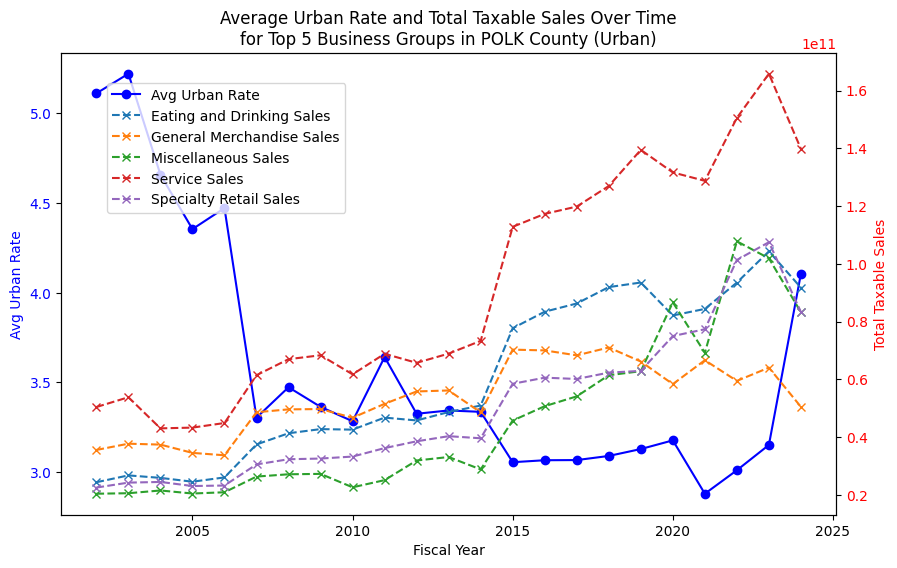

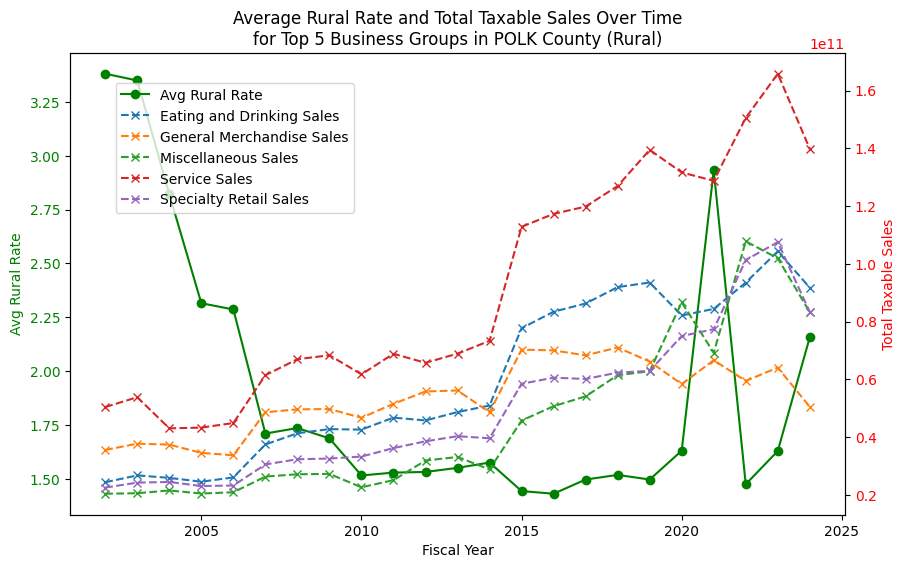

In [ ]:
# Chart 1: Plot Average Urban Rate and Total Taxable Sales Over Time for Top 5 Business Groups
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot county-level average urban rate on the left y-axis
ax1.plot(rates_df["fiscal_year"], rates_df["avg_urban_rate"], marker='o', color='blue', label='Avg Urban Rate')
ax1.set_xlabel("Fiscal Year")
ax1.set_ylabel("Avg Urban Rate", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for total taxable sales of each business group
ax2 = ax1.twinx()
for group in sales_pivot.columns:
    ax2.plot(sales_pivot.index, sales_pivot[group], marker='x', linestyle='--', label=f"{group} Sales")
ax2.set_ylabel("Total Taxable Sales", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Combine legends from both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0.05, 0.95))

plt.title("Average Urban Rate and Total Taxable Sales Over Time\nfor Top 5 Business Groups in POLK County (Urban)")
plt.show()

# Chart 2: Plot Average Rural Rate and Total Taxable Sales Over Time for Top 5 Business Groups
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot county-level average rural rate on the left y-axis
ax1.plot(rates_df["fiscal_year"], rates_df["avg_rural_rate"], marker='o', color='green', label='Avg Rural Rate')
ax1.set_xlabel("Fiscal Year")
ax1.set_ylabel("Avg Rural Rate", color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a second y-axis for total taxable sales of each business group
ax2 = ax1.twinx()
for group in sales_pivot.columns:
    ax2.plot(sales_pivot.index, sales_pivot[group], marker='x', linestyle='--', label=f"{group} Sales")
ax2.set_ylabel("Total Taxable Sales", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Combine legends from both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0.05, 0.95))

plt.title("Average Rural Rate and Total Taxable Sales Over Time\nfor Top 5 Business Groups in POLK County (Rural)")
plt.show()
